Using transfer learning , perform image classification of yoga poses.
Pretrained model : Xception

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import os
import cv2

Read in images with Xception preprocessing.

In [2]:
from keras.preprocessing.image import ImageDataGenerator

xception_preprocess = tf.keras.applications.xception.preprocess_input
##
image_path = "../input/yoga-poses-cgi/train"
test_path = "../input/yoga-poses-cgi/test"
##

train_data_gen = ImageDataGenerator(preprocessing_function = xception_preprocess, validation_split = 0.2)
test_data_gen = ImageDataGenerator(preprocessing_function = xception_preprocess)


##
train_ds = train_data_gen.flow_from_directory(image_path , target_size=(224, 224),
        batch_size=32 ,subset = 'training' , seed = 123 , class_mode = 'categorical', color_mode = 'rgb', shuffle = True, save_format = 'jpg')
val_ds = train_data_gen.flow_from_directory(image_path , target_size=(224, 224),
        batch_size=32 ,subset = 'validation' , seed = 123 , class_mode = 'categorical', color_mode = 'rgb', shuffle = True, save_format = 'jpg')

test_ds = test_data_gen.flow_from_directory(test_path ,target_size=(224, 224),
        batch_size=32 ,class_mode = 'categorical', color_mode = 'rgb', shuffle = True, save_format = 'jpg')

Found 800 images belonging to 5 classes.
Found 200 images belonging to 5 classes.
Found 495 images belonging to 5 classes.


In [3]:
labels = (train_ds.class_indices)
labels_dict = dict((v,k) for k,v in labels.items())
labels_dict

{0: 'chair', 1: 'cobra', 2: 'dog', 3: 'tree', 4: 'warrior'}

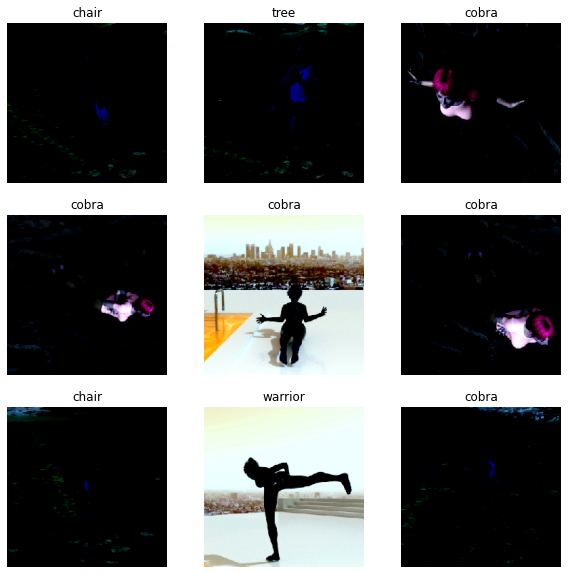

In [4]:
## visualize train set images
image_batch, label_batch = next(iter(train_ds))
label_batch = np.argmax(label_batch,axis=1)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(cv2.cvtColor(image_batch[i], cv2.COLOR_BGR2RGB))
    label = label_batch[i]
    name = labels_dict[label]
    plt.title(name)
    plt.axis("off")


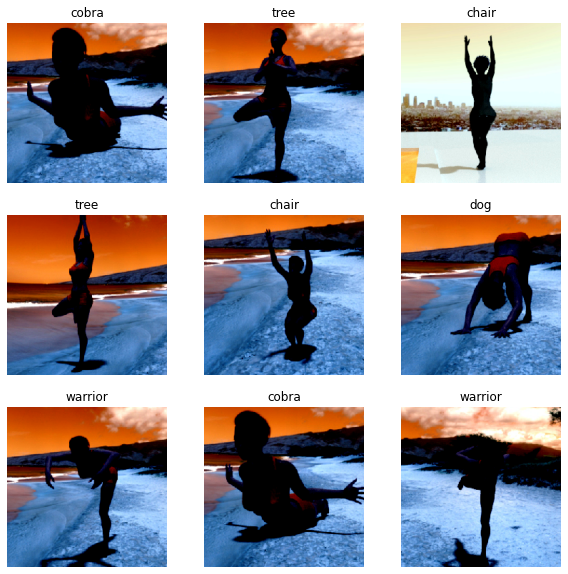

In [5]:
## visualize validation images 
image_batch, label_batch = next(iter(val_ds))
label_batch = np.argmax(label_batch,axis=1)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #plt.imshow(image_batch[i])
    plt.imshow(cv2.cvtColor(image_batch[i], cv2.COLOR_BGR2RGB))
    label = label_batch[i]
    name = labels_dict[label]
    plt.title(name)
    plt.axis("off")

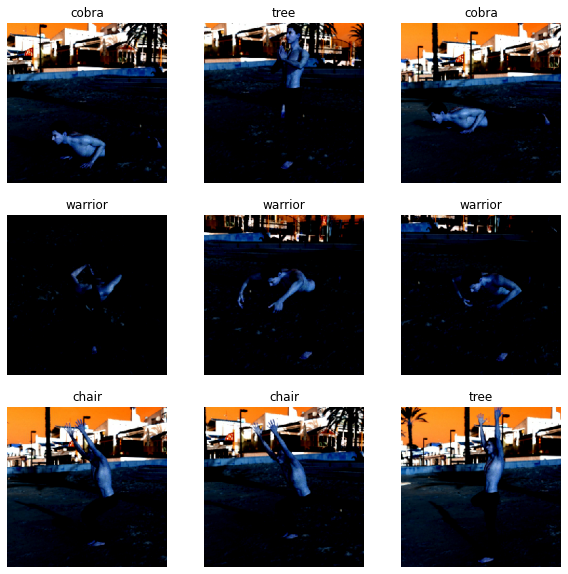

In [6]:
## visualize test images 
image_batch, label_batch = next(iter(test_ds))
label_batch = np.argmax(label_batch,axis=1)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #plt.imshow(image_batch[i])
    plt.imshow(cv2.cvtColor(image_batch[i], cv2.COLOR_BGR2RGB))
    label = label_batch[i]
    name = labels_dict[label]
    plt.title(name)
    plt.axis("off")

2022-02-19 10:12:58.033585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 10:12:58.133997: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 10:12:58.134758: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-19 10:12:58.135948: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 22,964,781
Trainable params: 2,103,301
Non-trainable params: 20,861,480
_________________________________________________________________


2022-02-19 10:13:02.173272: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-19 10:13:05.510432: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Classification Report for new test images 
              precision    recall  f1-score   support

       chair       1.00      0.75      0.86        81
       cobra       0.98      0.93      0.96       105
         dog       0.58      0.98      0.73        85
        tree       0.84      0.99      0.91        90
     warrior       1.00      0.53      0.69       102

    accuracy                           0.83       463
   macro avg       0.88      0.84      0.83       463
weighted avg       0.89      0.83      0.83       463



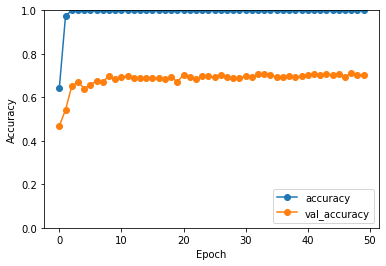

In [7]:
## Transfer learning with Xception . 
base_Net = tf.keras.applications.Xception(include_top = False, 
                         weights ='imagenet', 
                         input_shape = (224,224,3), 
                         pooling='avg',
                         )

base_Net.trainable = False
#Adding the final layers to the above base models where the actual classification is done in the dense layers
model_Net = tf.keras.models.Sequential()
model_Net.add(base_Net)
model_Net.add(tf.keras.layers.Dense(1024))
model_Net.add(tf.keras.layers.Dense(5, activation=tf.nn.softmax))

model_Net.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_Net.summary()

STEP_SIZE_TRAIN=train_ds.n//train_ds.batch_size
STEP_SIZE_VALID=val_ds.n//val_ds.batch_size
STEP_SIZE_TEST=train_ds.n//train_ds.batch_size

# Training the CNN on the Train data and evaluating it on the val data
%time history = model_Net.fit(train_ds , steps_per_epoch=STEP_SIZE_TRAIN ,  validation_data = val_ds, validation_steps=STEP_SIZE_VALID , epochs = 50, verbose = 0 )

##
test_loss, test_acc = model_Net.evaluate(test_ds , steps=STEP_SIZE_TEST)
print("Test image accuracy :{}".format(test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
##
model_Net.save('model_xcep_1')

loops = int(np.round(test_ds.n/32)) ## no of batches 
actual = np.array([])
predicted = np.array([])
img = []
for k in range(loops):
    x,y = test_ds.next()
    predictions =  np.argmax(model_Net.predict(x), axis = -1)
    img.append(x)
    predicted = np.concatenate([predicted ,predictions])
    actual = np.concatenate([actual , np.argmax(y,axis=1)])
    
##
print('Classification Report for new test images ')
print(classification_report(actual, predicted, target_names=[v for k,v in labels_dict.items()]))
##



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5125      
Total params: 22,964,781
Trainable params: 2,103,301
Non-trainable params: 20,861,480
_________________________________________________________________
CPU times: user 3min 20s, sys: 12.8 s, total: 3min 33s
Wall time: 3min 24s
25/25 [==============================] - 2s 77ms/step - loss: 1.2084 - accuracy: 0.8081
Test image accuracy :0.808080792427063


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Classification Report for new test images 
              precision    recall  f1-score   support

       chair       1.00      0.72      0.84        80
       cobra       0.99      0.99      0.99       114
         dog       0.53      0.85      0.66        88
        tree       0.88      0.96      0.92        93
     warrior       0.80      0.50      0.62       105

    accuracy                           0.81       480
   macro avg       0.84      0.81      0.80       480
weighted avg       0.85      0.81      0.81       480

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)         

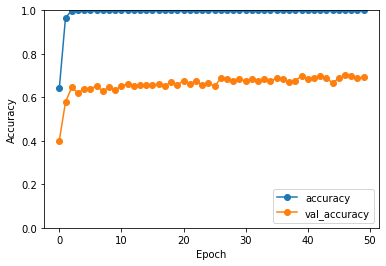

In [8]:
## Transfer learning with Xception . With drop out 
base_Net = tf.keras.applications.Xception(include_top = False, 
                         weights ='imagenet', 
                         input_shape = (224,224,3), 
                         pooling='avg',
                         )

base_Net.trainable = False
#Adding the final layers to the above base models where the actual classification is done in the dense layers
model_Net = tf.keras.models.Sequential()
model_Net.add(base_Net)
model_Net.add(tf.keras.layers.Dense(1024))
model_Net.add(tf.keras.layers.Dropout(0.2))
model_Net.add(tf.keras.layers.Dense(5, activation=tf.nn.softmax))

model_Net.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_Net.summary()

STEP_SIZE_TRAIN=train_ds.n//train_ds.batch_size
STEP_SIZE_VALID=val_ds.n//val_ds.batch_size
STEP_SIZE_TEST=train_ds.n//train_ds.batch_size

# Training the CNN on the Train data and evaluating it on the val data
%time history = model_Net.fit(train_ds , steps_per_epoch=STEP_SIZE_TRAIN ,  validation_data = val_ds, validation_steps=STEP_SIZE_VALID , epochs = 50, verbose = 0 )

##
test_loss, test_acc = model_Net.evaluate(test_ds,  steps=STEP_SIZE_TEST)
print("Test image accuracy :{}".format(test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
##
model_Net.save('model_xcep_2')

## for test data set , check the classification report.
loops = int(np.round(test_ds.n/32)) ## no of batches 
actual = np.array([])
predicted = np.array([])
img = []
for k in range(loops):
    x,y = test_ds.next()
    predictions =  np.argmax(model_Net.predict(x), axis = -1)
    img.append(x)
    predicted = np.concatenate([predicted ,predictions])
    actual = np.concatenate([actual , np.argmax(y,axis=1)])
    
##
print('Classification Report for new test images ')
print(classification_report(actual, predicted, target_names=[v for k,v in labels_dict.items()]))
##
model_Net.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 2565      
Total params: 21,913,133
Trainable params: 1,051,653
Non-trainable params: 20,861,480
_________________________________________________________________
CPU times: user 3min 20s, sys: 12.3 s, total: 3min 32s
Wall time: 3min 24s
25/25 [==============================] - 2s 73ms/step - loss: 1.0366 - accuracy: 0.7879
Test image accuracy :0.7878788113594055


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Classification Report for new test images 
              precision    recall  f1-score   support

       chair       1.00      0.72      0.84        79
       cobra       1.00      0.85      0.92       110
         dog       0.47      0.99      0.64        83
        tree       0.91      0.95      0.93        92
     warrior       0.98      0.43      0.60        99

    accuracy                           0.78       463
   macro avg       0.87      0.79      0.78       463
weighted avg       0.88      0.78      0.79       463

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_5 (Dense)              (None, 5)            

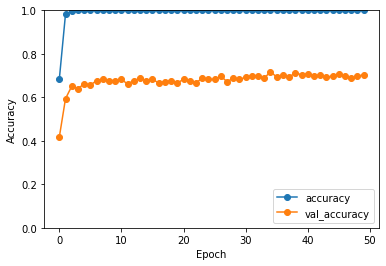

In [9]:
## Transfer learning with Xception . with 512 neurons
base_Net = tf.keras.applications.Xception(include_top = False, 
                         weights ='imagenet', 
                         input_shape = (224,224,3), 
                         pooling='avg',
                         )

base_Net.trainable = False
#Adding the final layers to the above base models where the actual classification is done in the dense layers
model_Net = tf.keras.models.Sequential()
model_Net.add(base_Net)
model_Net.add(tf.keras.layers.Dense(512))
model_Net.add(tf.keras.layers.Dense(5, activation=tf.nn.softmax))

model_Net.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_Net.summary()

STEP_SIZE_TRAIN=train_ds.n//train_ds.batch_size
STEP_SIZE_VALID=val_ds.n//val_ds.batch_size
STEP_SIZE_TEST=train_ds.n//train_ds.batch_size

# Training the CNN on the Train data and evaluating it on the val data
%time history = model_Net.fit(train_ds , steps_per_epoch=STEP_SIZE_TRAIN ,  validation_data = val_ds, validation_steps=STEP_SIZE_VALID , epochs = 50, verbose = 0 )

##
test_loss, test_acc = model_Net.evaluate(test_ds, steps = STEP_SIZE_TEST)
print("Test image accuracy :{}".format(test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
##
model_Net.save('model_xcep_3')

## for test data set , check the classification report.
loops = int(np.round(test_ds.n/32)) ## no of batches 
actual = np.array([])
predicted = np.array([])
img = []
for k in range(loops):
    x,y = test_ds.next()
    predictions =  np.argmax(model_Net.predict(x), axis = -1)
    img.append(x)
    predicted = np.concatenate([predicted ,predictions])
    actual = np.concatenate([actual , np.argmax(y,axis=1)])
    
##
print('Classification Report for new test images ')
print(classification_report(actual, predicted, target_names=[v for k,v in labels_dict.items()]))
##
print(model_Net.summary())

#### Test model on new images of yoga pose. 

In [10]:
## read in all the new test yoga poses and check the prediction 

test_path_2 = "../input/new-yoga-poses/yoga_test_data"
test_ds_2 = test_data_gen.flow_from_directory(test_path_2 ,target_size=(224, 224),
        batch_size=32 ,class_mode = 'categorical', color_mode = 'rgb', shuffle = True, save_format = 'jpg')


Found 26 images belonging to 5 classes.


In [11]:
## load the model 
model = tf.keras.models.load_model('./model_xcep_1')
##

loops = int(np.round(test_ds_2.n/32)) ## no of batches 
actual = np.array([])
predicted = np.array([])
img = []
for k in range(loops):
    x,y = test_ds_2.next()
    predictions =  np.argmax(model.predict(x), axis = -1)
    img.append(x)
    predicted = np.concatenate([predicted ,predictions])
    actual = np.concatenate([actual , np.argmax(y,axis=1)])
    
##
print('Classification Report for new test images ')
print(classification_report(actual, predicted, target_names=[v for k,v in labels_dict.items()]))

Classification Report for new test images 
              precision    recall  f1-score   support

       chair       1.00      0.33      0.50         6
       cobra       0.67      0.40      0.50         5
         dog       0.56      1.00      0.71         5
        tree       0.75      0.60      0.67         5
     warrior       0.62      1.00      0.77         5

    accuracy                           0.65        26
   macro avg       0.72      0.67      0.63        26
weighted avg       0.73      0.65      0.63        26



In [12]:
## load the model 
model = tf.keras.models.load_model('./model_xcep_2')
##

loops = int(np.round(test_ds_2.n/32)) ## no of batches 
actual = np.array([])
predicted = np.array([])
img = []
for k in range(loops):
    x,y = test_ds_2.next()
    predictions =  np.argmax(model.predict(x), axis = -1)
    img.append(x)
    predicted = np.concatenate([predicted ,predictions])
    actual = np.concatenate([actual , np.argmax(y,axis=1)])
    
##
print('Classification Report for new test images ')
print(classification_report(actual, predicted, target_names=[v for k,v in labels_dict.items()]))

Classification Report for new test images 
              precision    recall  f1-score   support

       chair       1.00      0.33      0.50         6
       cobra       0.67      0.80      0.73         5
         dog       0.62      1.00      0.77         5
        tree       0.50      0.40      0.44         5
     warrior       0.67      0.80      0.73         5

    accuracy                           0.65        26
   macro avg       0.69      0.67      0.63        26
weighted avg       0.70      0.65      0.63        26



In [13]:
## load the model 
model = tf.keras.models.load_model('./model_xcep_3')
##

loops = int(np.round(test_ds_2.n/32)) ## no of batches 
actual = np.array([])
predicted = np.array([])
img = []
for k in range(loops):
    x,y = test_ds_2.next()
    predictions =  np.argmax(model.predict(x), axis = -1)
    img.append(x)
    predicted = np.concatenate([predicted ,predictions])
    actual = np.concatenate([actual , np.argmax(y,axis=1)])
    
##
print('Classification Report for new test images ')
print(classification_report(actual, predicted, target_names=[v for k,v in labels_dict.items()]))

Classification Report for new test images 
              precision    recall  f1-score   support

       chair       1.00      0.33      0.50         6
       cobra       0.75      0.60      0.67         5
         dog       0.56      1.00      0.71         5
        tree       1.00      0.60      0.75         5
     warrior       0.62      1.00      0.77         5

    accuracy                           0.69        26
   macro avg       0.79      0.71      0.68        26
weighted avg       0.79      0.69      0.67        26



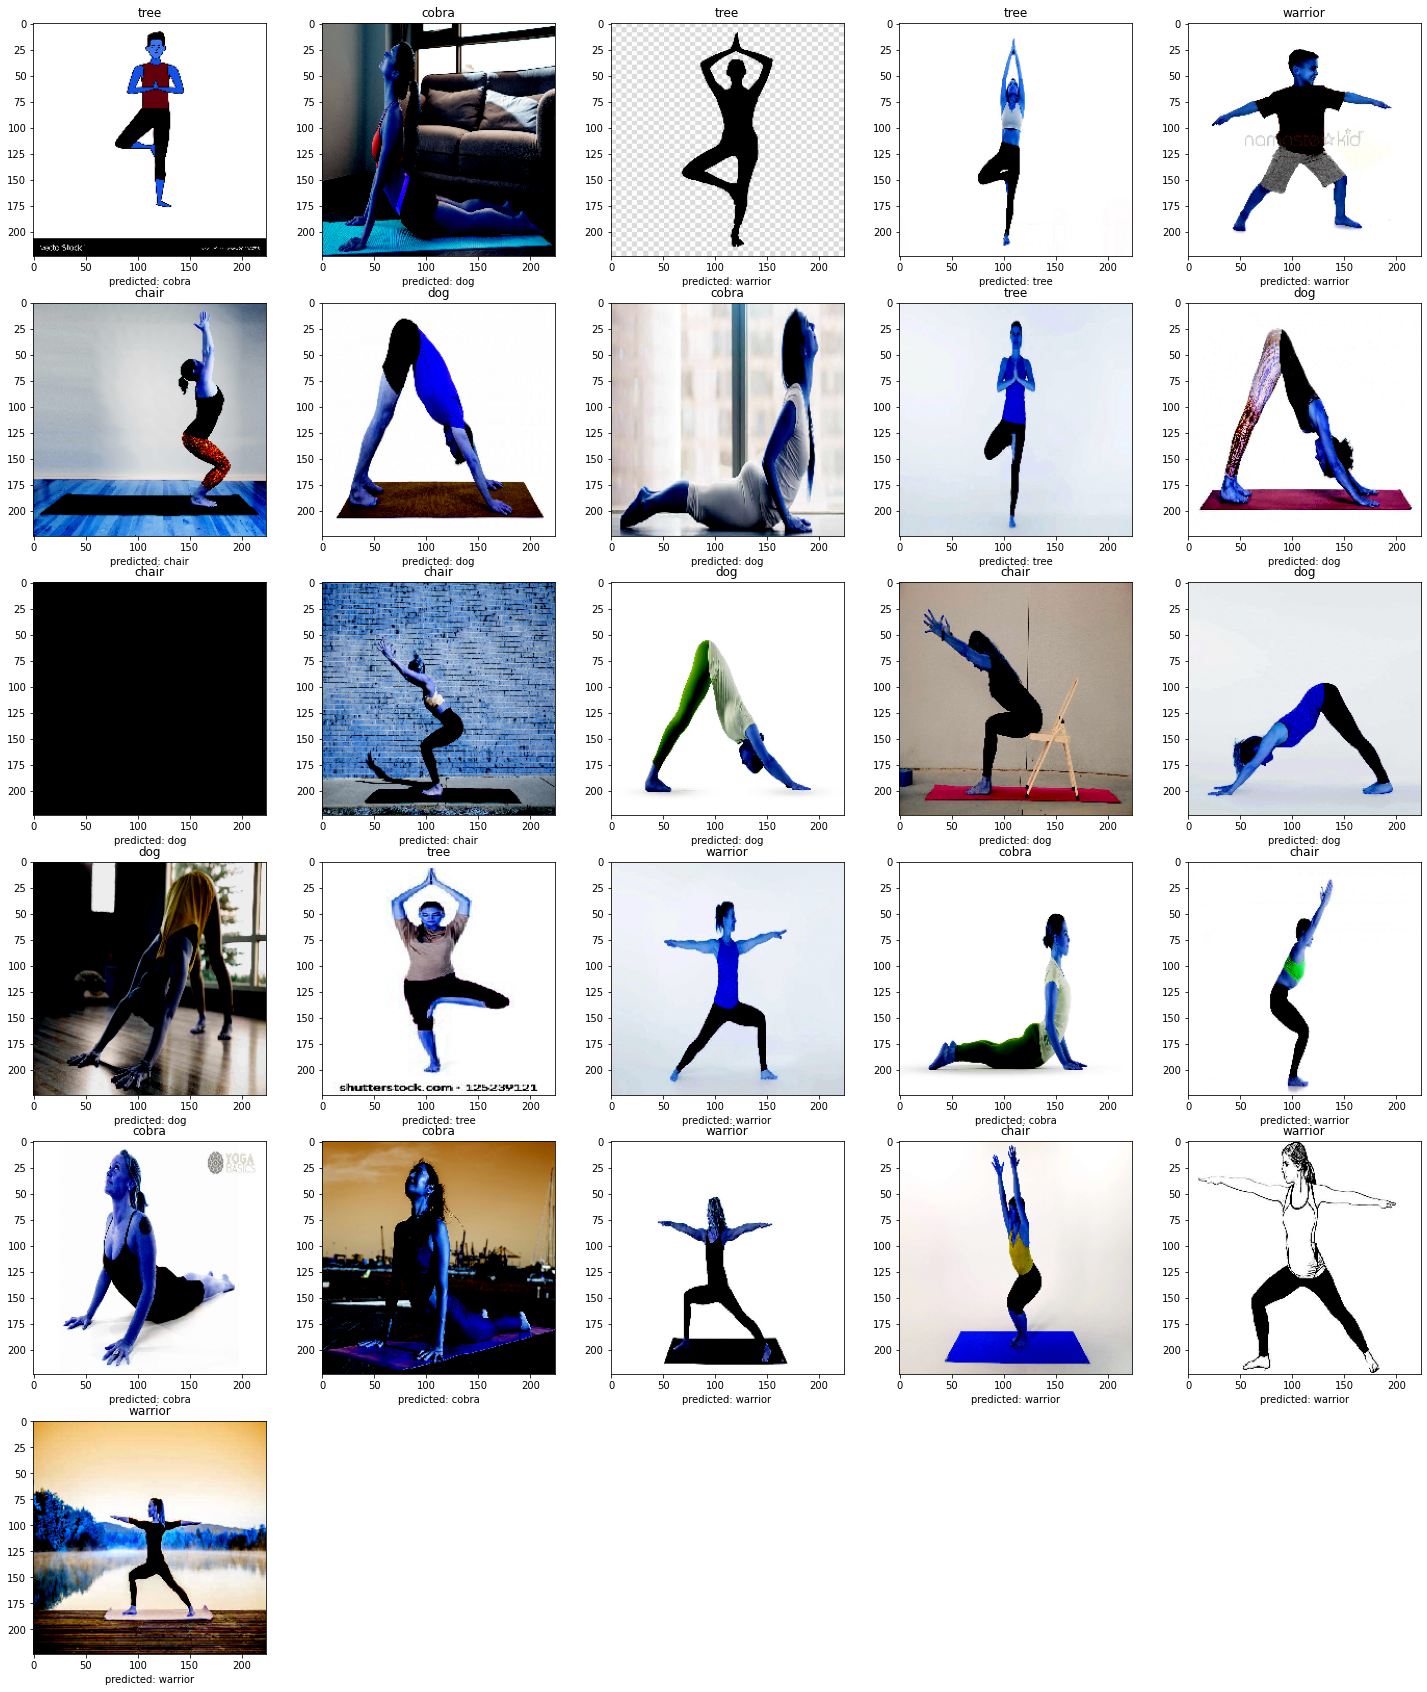

In [14]:
## visualize images with their prediction 

plt.figure(figsize=(25, 30))
for i in range(26):
    ax = plt.subplot(6, 5, i + 1)
    
    plt.imshow(cv2.cvtColor(img[0][i], cv2.COLOR_BGR2RGB))
    label = actual[i]
    pred_label = predicted[i]
    name = labels_dict[label]
    plt.title(name)
    plt.xlabel('predicted: ' + labels_dict[pred_label])
    #plt.axis("off")

Summary :

Transfer learning with Xception gives best test image accuracy of 0.83. On the new images downloaded from the internet , which consists of non CGI origin , the accuracy is 0.69.